<a href="https://www.kaggle.com/code/handandegerli/flo-cltv-prediction?scriptVersionId=180553251" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

CLTV Forecast with BG-NBD and Gamma-Gamma
---


**Install Packages**

In [1]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.7 MB/s eta 0:00:00


**Import Libraries**

In [2]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

# 1) Preparing the Data
---

**Task 1: Read file**

In [3]:
df_ = pd.read_csv('/kaggle/input/cltvpredictionflodataset/flo_data_20k.csv')

In [4]:
df = df_.copy()

In [5]:
df.shape

(19945, 12)

In [6]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


**Task 2: Outlier Threshold Functions**

In [8]:
def outlier_threshold(dataframe, variable):
    
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile = quartile3 - quartile1
    up_limit = quartile3 + 1.5*interquantile
    low_limit = quartile1 - 1.5*interquantile
    
    return round(low_limit), round(up_limit)

def replace_with_outlier(dataframe, variable):
    
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

**Task 3: Use threshold function for numerical variables**

In [9]:
num_cols = ['order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online']

for col in num_cols:
    replace_with_outlier(df, col)

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.0920,3.8095,1.0000,1.0000,2.0000,4.0000,48.0000
order_num_total_ever_offline,19945.0000,1.8862,1.4347,1.0000,1.0000,1.0000,2.0000,16.0000
customer_value_total_ever_offline,19945.0000,251.9213,251.0237,10.0000,99.9900,179.9800,319.9700,3020.0000
customer_value_total_ever_online,19945.0000,489.7057,632.6098,12.9900,149.9800,286.4600,578.4400,7800.0000


**Task 4: Creating total_order and total_value variables**

In [11]:
df['total_order'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['total_value'] = df['customer_value_total_ever_offline'] + df['customer_value_total_ever_online']
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_order,total_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],2.0000,209.9800


**Task 5: Check the variables types and convert dates to datetime object**

In [12]:
df.dtypes

master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
total_order                          float64
total_value                          float64
dtype: object

In [13]:
dates = ['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline']
df[dates] = df[dates].apply(pd.to_datetime)

In [14]:
df.dtypes

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
total_order                                 float64
total_value                                 float64
dtype: object

# 2) Creating CLTV Dataset
---

**Task 1: Find the last order date and create a analysis date called today_date**

In [15]:
today_date = df['last_order_date'].max() + dt.timedelta(days=2)

In [16]:
today_date = dt.datetime(today_date.year, today_date.month, today_date.day)


In [17]:
df.head(3)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_order,total_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",5.0000,585.3200


**Task 2: Preparation of Lifetime Data Structure**


Recency: Last purchase - First purchase (weekly for each customer)\
T: Analyze date - First purchase (weekly for each customer)\
Frequency: Total number of repeat purchases (frequency > 1)\
Monetary: Average value for each purchase

**Task 1-2: You take 2 days after the increase in the data set and the last purchase as the analysis date. We merge a new cltv dataframe with customer_id, recency_cltv_weekly, T_weekly, frequency and monetary_cltv_avg values. Monetary value will be expressed as the average value per purchase, and currency and lifespan values will be expressed in weekly terms.**

In [18]:
cltv_df = pd.DataFrame()

In [19]:
cltv_df['customer_id'] = df['master_id']

In [20]:
cltv_df['recency_cltv_weekly'] = (df['last_order_date']- df['first_order_date']).dt.days / 7


In [21]:
cltv_df['t_weekly'] = (df['first_order_date'].apply(lambda x: (today_date - x))).dt.days / 7

In [22]:
cltv_df['frequency'] = df['total_order']

In [23]:
cltv_df['monetary_cltv_avg'] = df['total_value'] / cltv_df['frequency']

In [24]:
cltv_df.sort_values('monetary_cltv_avg', ascending=False)

,customer_id,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671
15516,9083981a-f59e-11e9-841e-000d3a38a36f,63.5714,83.8571,4.0000,1090.3600
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900
16410,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,57.0000,94.8571,2.0000,859.5800
...,...,...,...,...,...
19341,0dd9a790-7d63-11ea-80af-000d3a38a36f,13.8571,59.1429,2.0000,26.7350
7693,1e2dd6cc-0b1e-11eb-8ffc-000d3a38a36f,20.7143,33.4286,2.0000,24.9900
9621,1b22a066-d68b-11e9-93bc-000d3a38a36f,45.8571,96.1429,3.0000,22.6567
14980,0769f8d0-d627-11e9-93bc-000d3a38a36f,58.8571,93.4286,2.0000,22.4900


# 3) BG/NBD and Gamma-Gamma Modelling and CLTV Calculations
---

**Task 1: Establishment of BG/NBD Model**

**Estimate the expected purchases from customers within 3 and 6 months and add them to the cltv dataframe as exp_sales_3_month, exp_sales_6_month, respectively.**

In [25]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [26]:
bgf.fit(cltv_df['frequency'],
       cltv_df['recency_cltv_weekly'],
       cltv_df['t_weekly'])

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [27]:
cltv_df['exp_sales_3_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(12,
                                                                                           cltv_df['frequency'],
                                                                                           cltv_df['recency_cltv_weekly'],
                                                                                           cltv_df['t_weekly'])

In [28]:
cltv_df['exp_sales_6_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(24,
                                                                                      cltv_df['frequency'],
                                                                                      cltv_df['recency_cltv_weekly'],
                                                                                      cltv_df['t_weekly'])


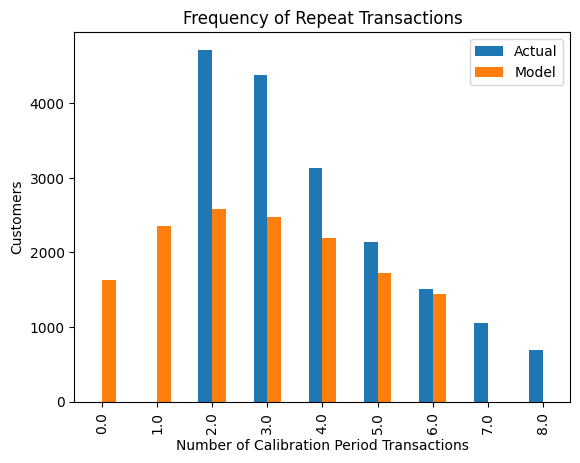

In [29]:
plot_period_transactions(bgf)
plt.show()

**Task 2: Establishment of Gamma-Gamma Model**

**Estimate the average value that customers will leave and add it to the cltv dataframe as exp_average_value.**

In [30]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [31]:
ggf.fit(cltv_df['frequency'],
       cltv_df['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [32]:
cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'], 
                                       cltv_df['monetary_cltv_avg'])

In [33]:
cltv_df.set_index('customer_id', inplace=True)

In [34]:
cltv_df.head()

,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
customer_id,,,,,,,
cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327
f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650
69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676
1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201
d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251


**Calculate 6-month CLTV and add it to the dataframe with the name cltv. Observe the 20 people with the highest Cltv values.**

In [35]:
cltv = ggf.customer_lifetime_value(bgf,
                                  cltv_df['frequency'],
                                  cltv_df['recency_cltv_weekly'],
                                  cltv_df['t_weekly'],
                                  cltv_df['monetary_cltv_avg'],
                                  time=6,
                                  freq='W',
                                   discount_rate=0.01
                                  )

In [36]:
cltv = cltv.reset_index()

In [37]:
cltv_final = cltv_df.merge(cltv, on='customer_id', how='left')

In [38]:
cltv_final.sort_values('clv', ascending=False).head(20)

,customer_id,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000,1.0944,2.1888,1449.0605,3327.7770
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11.0000,758.0855,1.9701,3.9402,767.3606,3172.3944
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671,0.7222,1.4445,1127.6115,1708.9821
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16.0000,501.8737,1.5653,3.1306,506.1667,1662.6135
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123,166.7123,1628.8874
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8.0000,601.2262,1.2655,2.5309,611.4926,1623.8127
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900,0.7939,1.5878,923.6800,1538.8559
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614,262.0729,1529.2280
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676,229.6069,1485.8192
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3.0000,743.5867,0.8716,1.7431,778.0504,1422.9997


# 4) Customer Segments according to CLV
---

**Divide all your customers into 4 groups (segments) according to 6-month CLTV and add the group names to the data set.**

In [39]:
cltv_final['segments'] = pd.qcut(cltv_final['clv'], 4, labels=['D', 'B', 'C', 'A'])

In [40]:
cltv_final.head()

,customer_id,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv,segments
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307,C
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242,C
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117,D


In [41]:
cltv_final.dtypes

customer_id              object
recency_cltv_weekly     float64
t_weekly                float64
frequency               float64
monetary_cltv_avg       float64
exp_sales_3_month       float64
exp_sales_6_month       float64
exp_average_value       float64
clv                     float64
segments               category
dtype: object

In [42]:
cltv_final.groupby("segments").agg(["count", "sum"])

customer_id                                                    recency_cltv_weekly             t_weekly             frequency            monetary_cltv_avg              exp_sales_3_month           exp_sales_6_month           exp_average_value                clv             
               count                                                sum               count         sum    count         sum     count        sum             count          sum             count       sum             count       sum             count          sum count          sum
segments                                                                                                                                                                                                                                                                                  
D               4987  1854e56c-491f-11eb-806e-000d3a38a36fd6ea1074-f...                4987 693193.8571     4987 808807.7143      4987 18795.0000              4987  464547.0459              4987 2039.1639              4987 4078.3277              4987  492172.4415  4987  400657.9551
B               4986  c445e4ee-6242-11ea-9d1a-000d3a38a36fec6c382a-3...                4986 461850.8571     4986 562512.1429      4986 21962.0000              4986  627181.6473              4986 2619.8846              4986 5239.7692              4986  659401.4525  4986  689621.1777
C               4986  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f69b69676-1...                4986 408794.0000     4986 500228.0000      4986 25392.0000              4986  800933.9587              4986 2997.1097              4986 5994.2195              4986  837650.8816  4986  994870.7838
A               4986  cc294636-19f0-11eb-8d74-000d3a38a36fcfbda69e-5...                4986 336191.7143     4986 411592.8571      4986 33140.0000              4986 1140952.0746              4986 3854.3130              4986 7708.6260              4986 1186787.6390  4986 1806505.0889

**Make brief 6-month action suggestions to the management for 2 groups you choose among 4 groups.**

For A segment: feedback is important, early access, VIP, loyalty, special transactions, personalized offers, it is necessary to make people feel valued,

For D segment: we recommend package offers, personalized reminders, campaigns, promotions
